In [53]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import DataLoader, TensorDataset

import math, copy, time
import os
import pandas as pd
import torchinfo

import matplotlib.pyplot as plt
%matplotlib inline

#import warnings
#warnings.filterwarnings("ignore")

import lstm_encoder_decoder
import data_valuator
import funtions_for_dvrl

import plotting

## Import Data

In [66]:
x = torch.tensor([2, 4, 5, 7, 8, 10, 11, 13, 14, 16, 17, 19, 20, 18, 17, 15, 14, 12, 11, 9, 8, 6, 5, 3, 2, 0, 1]).view(27,1)
y = torch.tensor([1]).view(1,1)
for i in range(100):
    y = torch.cat((y,x), dim=0)

for j in range(2):
    y = torch.cat((y,y), dim=1)

y.shape

torch.Size([2701, 4])

In [67]:
dataset2 = y.numpy().astype(np.float64)
print(f"Shape : {dataset2.shape}, Data Type : {dataset2.dtype}")

Shape : (2701, 4), Data Type : float64


<function matplotlib.pyplot.show(close=None, block=None)>

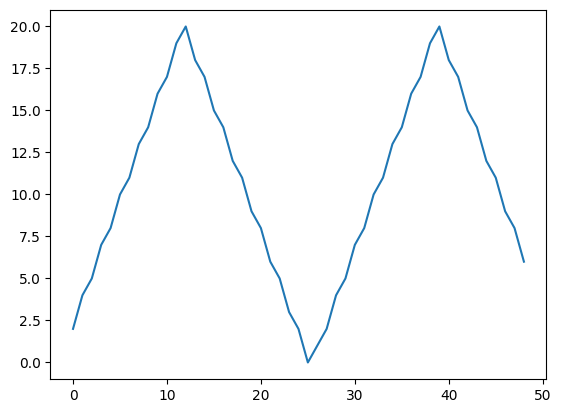

In [68]:
plt.plot(dataset2[1:50,2])
plt.show

## Corrupt Data

<function matplotlib.pyplot.show(close=None, block=None)>

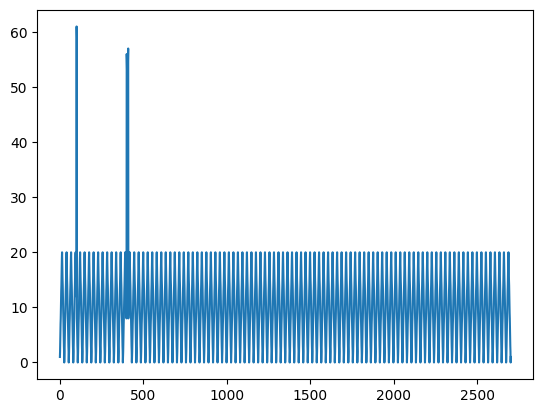

In [69]:
dataset2[100:102] += 50
dataset2[400:410] += 50
plt.plot(dataset2[:,2])
plt.show

## Convert Data Shape

In [70]:
train_split = 1000
lookback = 5
lookahead = 2
step = 1
batch_size = 45

x_train_multi, y_train_multi = funtions_for_dvrl.multivariate_data(dataset2, dataset2, 0,
                                                 train_split, lookback,
                                                 lookahead, step)
x_val_multi, y_val_multi = funtions_for_dvrl.multivariate_data(dataset2, dataset2,
                                             train_split, 1500, lookback,
                                             lookahead, step)

print (x_train_multi.shape,
       y_train_multi.shape,
       'Input size : {}'.format(x_train_multi[0].shape),
       'Target size to predict : {}'.format(y_train_multi[0].shape),
       sep='\n')

(995, 5, 4)
(995, 2, 4)
Input size : (5, 4)
Target size to predict : (2, 4)


In [71]:
#Extracting a single column for univariante time series
x_train = torch.from_numpy(x_train_multi[:,:,2])
y_train = torch.from_numpy(y_train_multi[:,:,2])
x_valid = torch.from_numpy(x_val_multi[1:100,:,2])
y_valid = torch.from_numpy(y_val_multi[1:100,:,2])

x_valid = torch.unsqueeze(x_valid,2)
x_valid = x_valid.transpose(1,0).float()

y_valid = torch.unsqueeze(y_valid,2)
y_valid = y_valid.transpose(1,0).float()
print(f"X Train Shape : {x_train.shape}")
print(f"Y Train Shape : {y_train.shape}")
print(f"X Valid Shape : {x_valid.shape}")
print(f"Y Valid Shape : {y_valid.shape}")

X Train Shape : torch.Size([995, 5])
Y Train Shape : torch.Size([995, 2])
X Valid Shape : torch.Size([5, 99, 1])
Y Valid Shape : torch.Size([2, 99, 1])


In [72]:
g = torch.Generator().manual_seed(2147483647)

## Make Model

In [73]:
def make_model(lookback = lookback, lookahead = lookahead, datavaluator_hidden = 64):
    "Helper: Construct a model from hyperparameters."
    #c = copy.deepcopy
    #data_valuator_mlp = Data_Valuator_MLP(lookback+lookahead, datavaluator_hidden)

    model_1 = data_valuator.Data_Valuator_MLP(lookback+lookahead, datavaluator_hidden)

    return model_1

In [74]:
model_1 = make_model()
moving_avg_loss = 0
criterion = nn.MSELoss()

In [75]:
torchinfo.summary(model_1, [(batch_size, lookback + lookahead)], dtypes=[torch.float64, torch.float64], col_names=["input_size", "output_size", 
                                                                                                 "num_params", "trainable"])

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #                   Trainable
Data_Valuator_MLP                        [45, 7]                   [45, 1]                   --                        True
├─Sequential: 1-1                        [45, 7]                   [45, 1]                   --                        True
│    └─Linear: 2-1                       [45, 7]                   [45, 64]                  512                       True
│    └─ReLU: 2-2                         [45, 64]                  [45, 64]                  --                        --
│    └─Linear: 2-3                       [45, 64]                  [45, 128]                 8,320                     True
│    └─ReLU: 2-4                         [45, 128]                 [45, 128]                 --                        --
│    └─Linear: 2-5                       [45, 128]                 [45, 64]                  8,256                     True
│    └─

## Train Model

In [76]:
for p in model_1.parameters():
    p.requires_grad = True #False

time_window_size = 45
reward = -10
mov_avg_plot = []
reward_plot = []
curr_loss_plot = []
iteration = []

In [77]:
reward = 0
model_4 = lstm_encoder_decoder.lstm_seq2seq(input_size = 1, hidden_size = 32)
num_of_epochs = 3
iter = 0
for i in range(num_of_epochs):
    for T in range(1000):
        
        #Make Time Window Batches
        if T == 980:
            break
        x_batch, y_batch = funtions_for_dvrl.MovingBatch(x_train, y_train, time_window_size, T)
        #Pass Throught Data Valuator MLP
        input = torch.cat((x_batch,y_batch), 1)
        prob_vector = model_1.forward(input)
        select = data_valuator.SelectionFromProb(prob_vector, g)
        select_for_lstm = select.clone().detach()
        x_selected_batch, y_selected_batch = funtions_for_dvrl.SelectBatches(x_batch, y_batch, select_for_lstm)
        if torch.all(select==0).item():
            continue
        #Reshape For LSTM
        x_selected_batch = torch.unsqueeze(x_selected_batch,2)
        x_selected_batch = x_selected_batch.transpose(1,0).float()
        y_selected_batch = torch.unsqueeze(y_selected_batch,2)
        y_selected_batch = y_selected_batch.transpose(1,0).float()
        #Pass Through LSTM
        loss = model_4.train_model(x_selected_batch, y_selected_batch, n_epochs = 1, target_len = lookahead, batch_size = x_selected_batch.shape[1], 
                             training_prediction = 'mixed_teacher_forcing', teacher_forcing_ratio = 0.6, learning_rate = 0.01, dynamic_tf = False)
        curr_lossi = lstm_encoder_decoder.predict_loss(model_4, x_valid, y_valid)
        curr_loss = torch.tensor(curr_lossi)
        #Update The Moving Average
        moving_avg_loss = funtions_for_dvrl.MAL(curr_loss, T+1, moving_avg_loss)
        #Determine The Log_Pi Loss And Reward Scale
        reward = curr_loss - moving_avg_loss
        data_valuator_loss = funtions_for_dvrl.DataValuator_LogPi(select, prob_vector)
        if torch.eq(reward,0).item():
            reward = torch.tensor(-1)
        #Update The Data Valuator Parameters
        reward_for_data = reward.clone().detach()
        data_valuator.Data_Valuator_Train(model_1, data_valuator_loss, reward_for_data)
        mov_avg_plot.append(moving_avg_loss)
        reward_plot.append(reward)
        curr_loss_plot.append(curr_loss)
        iteration.append(iter)
        iter+=1
        if T%100 == 0:
            print(f"curr_loss = {curr_loss}, mov_avg = {moving_avg_loss}, reward = {reward}")

curr_loss = 137.53904724121094, mov_avg = 137.53904724121094, reward = -1
curr_loss = 7.126779079437256, mov_avg = 25.027103424072266, reward = -17.90032386779785
curr_loss = 3.0187437534332275, mov_avg = 14.529279708862305, reward = -11.510536193847656
curr_loss = 1.6429009437561035, mov_avg = 10.361664772033691, reward = -8.71876335144043
curr_loss = 10.101329803466797, mov_avg = 9.780485153198242, reward = 0.3208446502685547
curr_loss = 2.2253942489624023, mov_avg = 8.575804710388184, reward = -6.350410461425781
curr_loss = 1.4522165060043335, mov_avg = 7.512608528137207, reward = -6.060391902923584
curr_loss = 0.8194838762283325, mov_avg = 6.707974433898926, reward = -5.888490676879883
curr_loss = 0.555232048034668, mov_avg = 6.045543670654297, reward = -5.490311622619629
curr_loss = 0.852887749671936, mov_avg = 5.482722282409668, reward = -4.6298346519470215
curr_loss = 0.8493199348449707, mov_avg = 0.8493199348449707, reward = -1
curr_loss = 1.7271969318389893, mov_avg = 5.497483

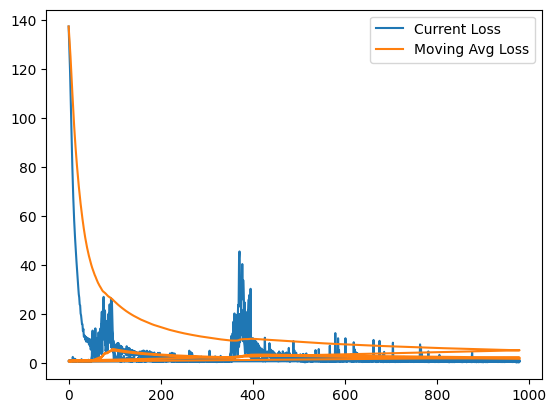

In [79]:
curr_loss_plot_list = [tensor for tensor in curr_loss_plot]
reward_plot_list = [tensor for tensor in reward_plot]
mov_avg_plot_list = [tensor for tensor in mov_avg_plot]
iteration_plot_list = iteration
plt.plot(iteration, curr_loss_plot_list, label='Current Loss')
plt.plot(iteration, mov_avg_plot_list, label='Moving Avg Loss')
#plt.plot(iteration, reward_plot_list, label='Reward')
#plt.plot(iteration, x_train[0:800,2], label='Dataset')
plt.legend()
plt.show()

In [80]:
torch.save({
            'num_of_epochs': num_of_epochs,
            'model_state_dict': model_1.state_dict(),
            'final_reward': reward
            }, 'C:/Users/poops/Desktop/Coding Shenanigans/RnDProject/plswork/data_valuator.pth')